<a href="https://colab.research.google.com/github/BhoomiShakya/Agentic_RAG_with_Langgraph/blob/main/Agentic_RAG_with_Langgraphh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   ***Annotated***: Used to add metadata to type hints.
*   **Literal**: Allows defining a specific set of values a variable can have.
*   **Sequence**: Represents ordered collections like lists and tuples.
*   **TypedDict**: Enables defining dictionary-like structures with type annotations.
*   **hub**: Provides access to predefined prompts and chains from LangChain Hub.
*   **BaseMessage**: Represents a general message in a conversation.
*   **HumanMessage**: Represents messages from a user in a chatbot interaction.
*   **StrOutputParser**: Converts AI-generated outputs into string format.
*   **PromptTemplate**: Helps structure prompts dynamically with placeholders.
*   **BaseModel**: A class from Pydantic used for structured data validation.
*   **Field**: Defines metadata for model attributes (like descriptions & default values).
*   **add_messages**: A function used to accumulate messages in a graph.

*   **tools_condition**: Helps conditionally execute tools within a workflow.
*   **ToolNode**: A prebuilt graph node that can execute LangChain tools.


*   **WebBaseLoader**: A loader that fetches and processes web page content.

*   **create_retriever_tool**: Converts a retriever into a usable tool within LangChain.















In [187]:
!pip install langgraph
!pip install langchain-community
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [188]:
!pip install langchain-huggingface
from langchain_huggingface import HuggingFaceEmbeddings

loading embedding model
  

In [189]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [190]:
!pip install langchain-groq
from langchain_groq import ChatGroq

creating a LLM model


In [191]:
llm = ChatGroq(model="llama3-70b-8192" , api_key="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")

In [192]:
llm.invoke("tell me about india")

AIMessage(content="India! A country with a rich history, diverse culture, and breathtaking natural beauty. Here's an overview:\n\n** Geography and Climate **\n\nIndia is a vast country located in South Asia, bordered by Pakistan, China, Nepal, Bhutan, Bangladesh, and Myanmar. It's the seventh-largest country in the world by land area and has a diverse geography, featuring:\n\n* The Himalayan mountain range in the north\n* The Indo-Gangetic Plain in the north and east\n* The Deccan Plateau in the south\n* The Eastern and Western Ghats, mountain ranges along the eastern and western coasts\n* Deserts in the northwest (Thar Desert) and southwest (Rann of Kutch)\n\nIndia's climate varies greatly, ranging from tropical in the south to temperate in the north. The country has four distinct seasons: winter (December to February), summer (March to May), monsoon (June to September), and post-monsoon (October to November).\n\n** Population and Languages **\n\nIndia is the second-most populous coun

RAG requires a data so these are the links that are going to responsible for fetching the data


In [193]:

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [194]:
docs = [WebBaseLoader(urls).load() for url in urls]

In [195]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [196]:
docs_list= [item for sublist in docs for item in sublist]

as the above links contain a lot of data so we need to perform chunking for better interpretation

In [197]:
!pip install tiktoken

In [198]:
TextSplitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=5)

In [199]:
doc_split= TextSplitter.split_documents(docs_list)

In [200]:
doc_split

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [201]:
!pip install chromadb

In [202]:
vectorstore = Chroma.from_documents(
    documents = doc_split,
    collection_name = "rag-chroma",
    embedding = embeddings
)

now creating a retriever will gonna retrieve output from the db


In [203]:
retriever = vectorstore.as_retriever()

converting this retriever into a tool


In [204]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
  "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",

)

In [205]:
tools =  [retriever_tool]

In [206]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

#going to create a AI Assistant with a help of some tool

In [207]:
def AI_Assistant(state:AgentState):
  print("-----CALL AGENT-----")
  messages= state['messages']
  llm_with_tool = llm.bind_tools(tools)
  response= llm_with_tool.invoke(messages)
  return {"messages":[response]}

In [208]:
def retriever(state):
  pass

In [209]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    print(f"here is message from generate: {messages}")

    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")

    return {"messages": [response]}

In [210]:
def rewriter(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    print(f"here is message from rewrite: {messages}")

    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning.
                    Here is the initial question: {question}
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [211]:
def grade_documents(state:AgentState):
    llm_with_structure_op=llm.with_structured_output(grade)

    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant.
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

this class basically to check whether the document is relevant or not

In [212]:
class grade(BaseModel):
  binary_score:str = Field(description="Relevance score 'yes' or 'no'")

these function are nothing but a node so...we need to define these as a node

In [213]:
workflow=StateGraph(AgentState)
workflow.add_node("AI_ASSITANT",AI_Assistant)
# retriever = ToolNode([retriever_tool]) #converting this tool into a Node
workflow.add_node("retriever",retriever)#consuming the Node inside the Flow
workflow.add_node("rewriter",rewriter)
workflow.add_node("generate",generate)


In [214]:
workflow.add_edge(START, "AI_ASSITANT")

workflow.add_conditional_edges("AI_ASSITANT",
                               tools_condition,
                               {"tools": "retriever",
                                END: END,})

In [215]:
workflow.add_conditional_edges("retriever",grade_documents, {
    "rewriter":"rewriter", "generate":"generate"
} )

In [216]:
workflow.add_edge("generate", END)


In [217]:
workflow.add_edge("rewriter", "AI_ASSITANT")


In [218]:
app= workflow.compile()

In [219]:
pip install graphviz pydot


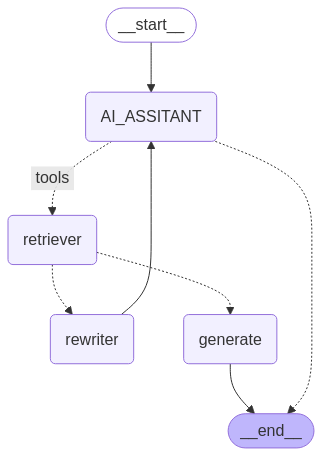

In [220]:
graph_image = app.get_graph(xray=True).draw_mermaid_png()

# Save the image to a file
with open("graph.png", "wb") as f:
    f.write(graph_image)

# Display the image manually
from IPython.display import display
display(Image("graph.png"))


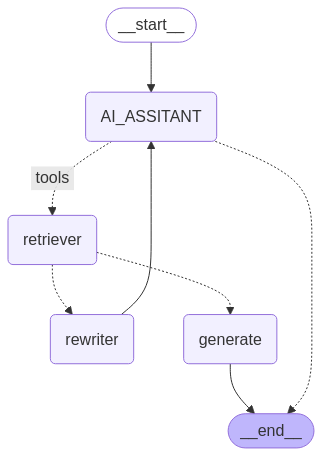

In [221]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [222]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

-----CALL AGENT-----
message from the grader: [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='7afa3039-373f-4222-8c1a-1f07f36282d9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sqt0', 'function': {'arguments': '{"query":"Autonomous Agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 1000, 'total_tokens': 1046, 'completion_time': 0.153941682, 'prompt_time': 0.036353274, 'queue_time': 0.24231387199999999, 'total_time': 0.190294956}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b98ae5fd-bb7f-4875-a076-2baf92b505fc-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Autonomous Agent'}, 'id': 'call_sqt0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1000, 'output_tokens': 46, 'total_tokens': 1046})]
---DECISION: DOCS

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


this is my response:content='An Autonomous Agent is a system that perceives its environment and takes actions to achieve a goal without external direction. It has the ability to make decisions and act independently, using its own intelligence and knowledge to adapt to changing situations. Autonomous agents are often used in applications such as robotics, drones, and self-driving cars.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 74, 'total_tokens': 138, 'completion_time': 0.265330304, 'prompt_time': 0.002524698, 'queue_time': 0.24911514699999998, 'total_time': 0.267855002}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'stop', 'logprobs': None} id='run-3215ccfd-bf2f-4e2d-88c7-9c62ed9fcfed-0' usage_metadata={'input_tokens': 74, 'output_tokens': 64, 'total_tokens': 138}


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='7afa3039-373f-4222-8c1a-1f07f36282d9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sqt0', 'function': {'arguments': '{"query":"Autonomous Agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 1000, 'total_tokens': 1046, 'completion_time': 0.153941682, 'prompt_time': 0.036353274, 'queue_time': 0.24231387199999999, 'total_time': 0.190294956}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b98ae5fd-bb7f-4875-a076-2baf92b505fc-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Autonomous Agent'}, 'id': 'call_sqt0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1000, 'output_tokens': 46, 'total_tokens': 1046}),
  AIMessage(content='An Autonomous Agent is a sy

In [223]:
app.invoke({"messages":["What is a prompt engineering?"]})

-----CALL AGENT-----
message from the grader: [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='ba52a54a-b9ce-466f-97b2-f38eb0ad12e4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jzpa', 'function': {'arguments': '{"query":"prompt engineering"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1000, 'total_tokens': 1045, 'completion_time': 0.151032227, 'prompt_time': 0.041702447, 'queue_time': 0.24606271500000002, 'total_time': 0.192734674}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f6307aa2-89da-40df-9f0b-4ef21f1657d8-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'prompt engineering'}, 'id': 'call_jzpa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1000, 'output_tokens': 45, 'total_tokens': 1045})]
---DECISION

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


this is my response:content="Based on the provided context, I don't have enough information to answer this question. The context is empty, and I couldn't find any relevant information about prompt engineering. I don't know what prompt engineering is." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 74, 'total_tokens': 118, 'completion_time': 0.1818525, 'prompt_time': 0.00226022, 'queue_time': 0.244838746, 'total_time': 0.18411272}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'stop', 'logprobs': None} id='run-338b6461-5049-42cc-ae73-33f0f6e145a9-0' usage_metadata={'input_tokens': 74, 'output_tokens': 44, 'total_tokens': 118}


{'messages': [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='ba52a54a-b9ce-466f-97b2-f38eb0ad12e4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jzpa', 'function': {'arguments': '{"query":"prompt engineering"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1000, 'total_tokens': 1045, 'completion_time': 0.151032227, 'prompt_time': 0.041702447, 'queue_time': 0.24606271500000002, 'total_time': 0.192734674}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f6307aa2-89da-40df-9f0b-4ef21f1657d8-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'prompt engineering'}, 'id': 'call_jzpa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1000, 'output_tokens': 45, 'total_tokens': 1045}),
  AIMessage(content="Based on the provided

In [224]:
app.invoke({"messages":["how to make maggi"]})

-----CALL AGENT-----


{'messages': [HumanMessage(content='how to make maggi', additional_kwargs={}, response_metadata={}, id='646aa54a-5c9f-4d0c-98e4-4eebc1b1ede4'),
  AIMessage(content='<tool-use>{"tool_calls": []}</tool-use>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 999, 'total_tokens': 1012, 'completion_time': 0.08400145, 'prompt_time': 0.035292333, 'queue_time': 0.241997279, 'total_time': 0.119293783}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-5118fb94-0ad8-4cec-ab60-1d59bdfe7c16-0', usage_metadata={'input_tokens': 999, 'output_tokens': 13, 'total_tokens': 1012})]}